In [24]:
import math

import pandas as pd
from pandas import DataFrame as DF

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:.3f}'.format)

def gnanc(df):
    """[G]et [NaN] [C]olumns"""
    columns = df.columns
    return DF({
        'column': columns,
        'hasNaN': [df[c].isnull().any() for c in columns],
        'NaNs': [df[c].isnull().sum() for c in columns]
    })

# Questão 2

> Esta questão aborda a aplicação prática de um problema de Ciência de Dados utilizando Machine Learning. O objetivo é prever se os indivíduos irão cancelar suas reservas em uma rede de hotéis, utilizando o conjunto de dados Hotel Booking Demand. Siga os passos abaixo para desenvolver sua solução.

## Análise Descritiva dos Dados

Carregando dados:

In [6]:
from brandedpipes import __
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "hotel_bookings.csv"

# Load the latest version
q2_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "jessemostipak/hotel-booking-demand",
  file_path,
)

q2_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.000,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.000,NaN,0,Transient,98.000,0,1,Check-Out,2015-07-03


### Sumários:

In [7]:
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [8]:
q2_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.000,0.370,0.483,0.000,0.000,0.000,1.000,1.000
lead_time,119390.000,104.011,106.863,0.000,18.000,69.000,160.000,737.000
arrival_date_year,119390.000,2016.157,0.707,2015.000,2016.000,2016.000,2017.000,2017.000
arrival_date_week_number,119390.000,27.165,13.605,1.000,16.000,28.000,38.000,53.000
arrival_date_day_of_month,119390.000,15.798,8.781,1.000,8.000,16.000,23.000,31.000
stays_in_weekend_nights,119390.000,0.928,0.999,0.000,0.000,1.000,2.000,19.000
stays_in_week_nights,119390.000,2.500,1.908,0.000,1.000,2.000,3.000,50.000
adults,119390.000,1.856,0.579,0.000,2.000,2.000,2.000,55.000
children,119386.000,0.104,0.399,0.000,0.000,0.000,0.000,10.000
babies,119390.000,0.008,0.097,0.000,0.000,0.000,0.000,10.000


### Colunas com null/NaN:

In [18]:
nan_df = gnanc(q2_df)
nan_df[nan_df['hasNaN']]

,column,hasNaN,NaNs
10,children,True,4
13,country,True,488
23,agent,True,16340
24,company,True,112593


### Total de registros:

In [20]:
len(q2_df)

119390

(A maior parte dos registros não têm empresa.)

### Variáveis categóricas

In [79]:
buckets = [
    'hotel', 'meal', 'market_segment', 'distribution_channel',
    'deposit_type', 'customer_type', 'reservation_status',
    'country', 'adults', 'children',
    'babies', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes',
    'days_in_waiting_list', 'required_car_parking_spaces',
    'total_of_special_requests', 'is_repeated_guest',
    'reservation_status'
]

buckets_df = DF({
    'dtype': [q2_df[b].dtype for b in buckets],
    'count': [q2_df[b].unique().size for b in buckets]
}, index=buckets)
buckets_df

,dtype,count
hotel,object,2
meal,object,5
market_segment,object,8
distribution_channel,object,5
deposit_type,object,3
customer_type,object,4
reservation_status,object,3
country,object,178
adults,int64,14
children,int64,5


In [83]:
categories_df = buckets_df[buckets_df['count'] < 10]

`children` deve ser inteiro. Único empecilho são meros 4 linhas com valor `nan` para children, quase certamente erros. Vamos converter para zero:

In [68]:
q2_df['children'] = q2_df['children'].fillna(0).astype(int, copy=False)

### Gráficos

#### Cancelamentos e não cancelamentos:

<Axes: xlabel='is_canceled', ylabel='count'>

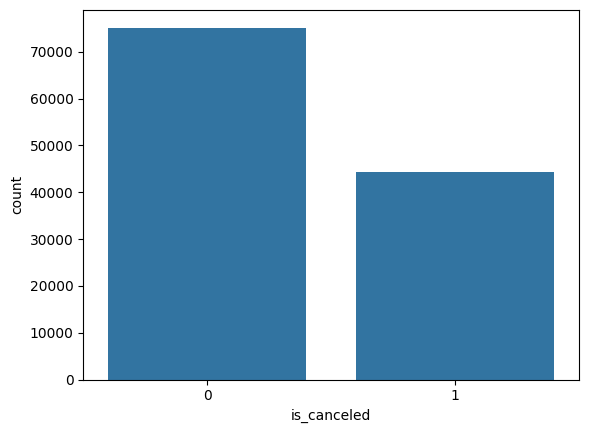

In [84]:
sns.countplot(data=q2_df, x="is_canceled")

Há uma diferença significativa, mas não parece tão impactante. Não vamos balancear a base.

#### Variáveis categóricas:

In [85]:
def countplots(df, columns, per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

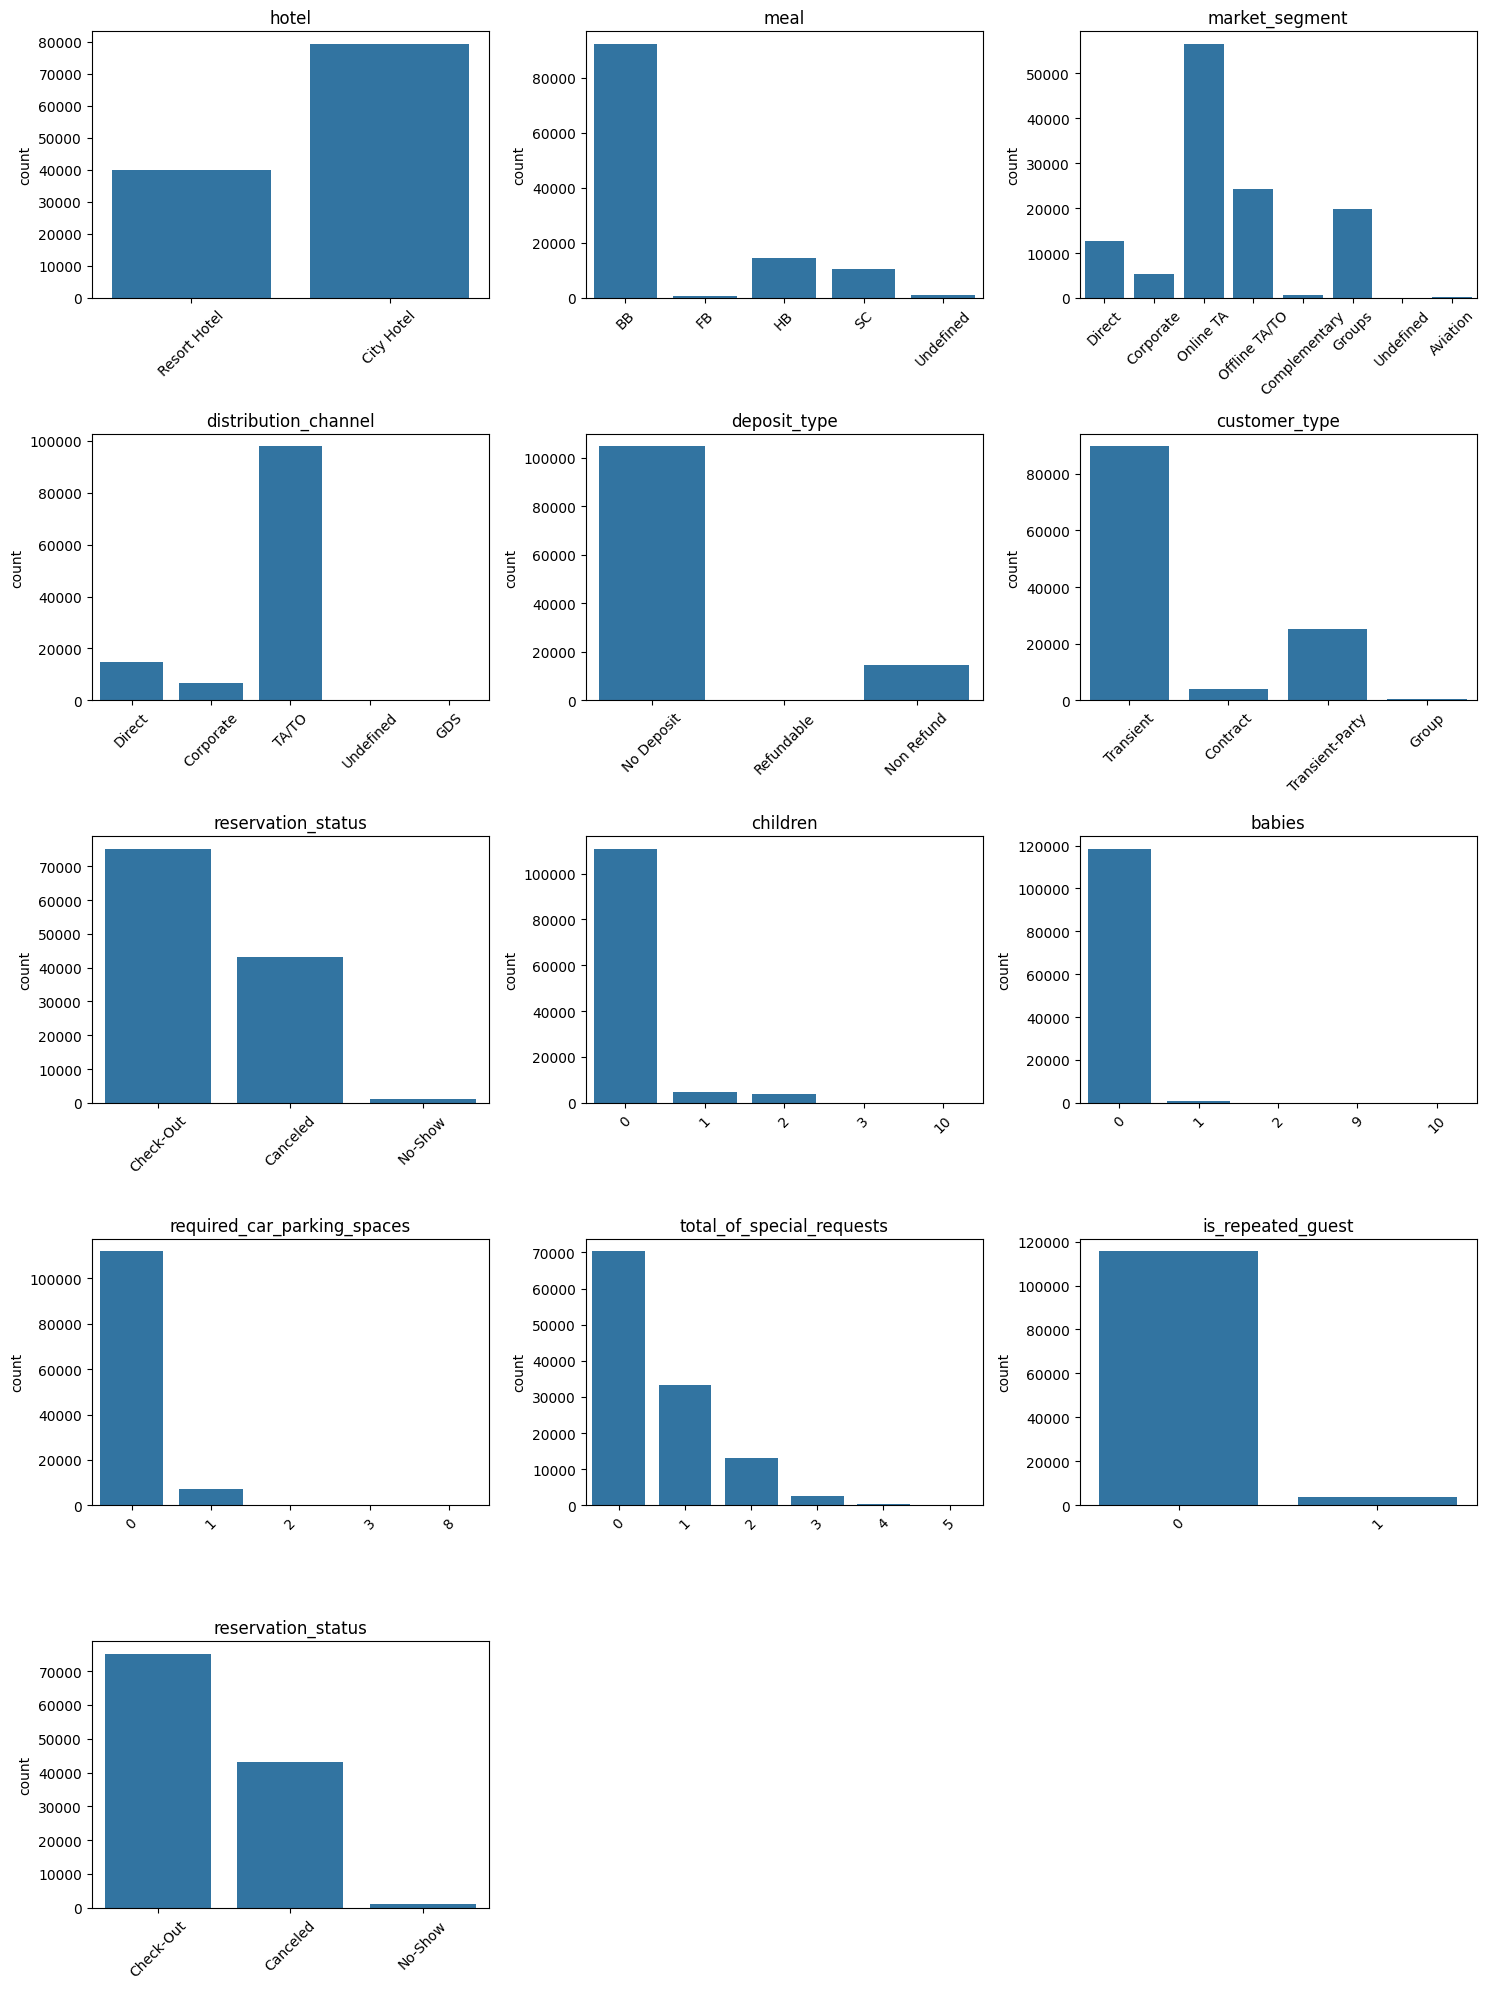

In [86]:
countplots(q2_df, categories_df.index)

#### Boxplot de variáveis numéricas

In [89]:
def boxplots(df, columns, per_row=3, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.boxplot(data=df, x=col, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [96]:
numeric = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'agent', 'company', 'days_in_waiting_list',
    'adr','total_of_special_requests'
]

numbers_df = DF({
    'dtype': [q2_df[b].dtype for b in numeric],
    'count': [q2_df[b].unique().size for b in numeric]
}, index=numeric)
numbers_df

,dtype,count
lead_time,int64,479
stays_in_weekend_nights,int64,17
stays_in_week_nights,int64,35
previous_cancellations,int64,15
previous_bookings_not_canceled,int64,73
booking_changes,int64,21
agent,float64,334
company,float64,353
days_in_waiting_list,int64,128
adr,float64,8879


Vamos separar os valores em duas partes: aqueles que tem número relativamente limitado de valores ("countings") e os que são praticamente ilimitados.

In [99]:
countings_df = numbers_df[numbers_df['count'] <= 50]
unbound_df = numbers_df[numbers_df['count'] > 50]

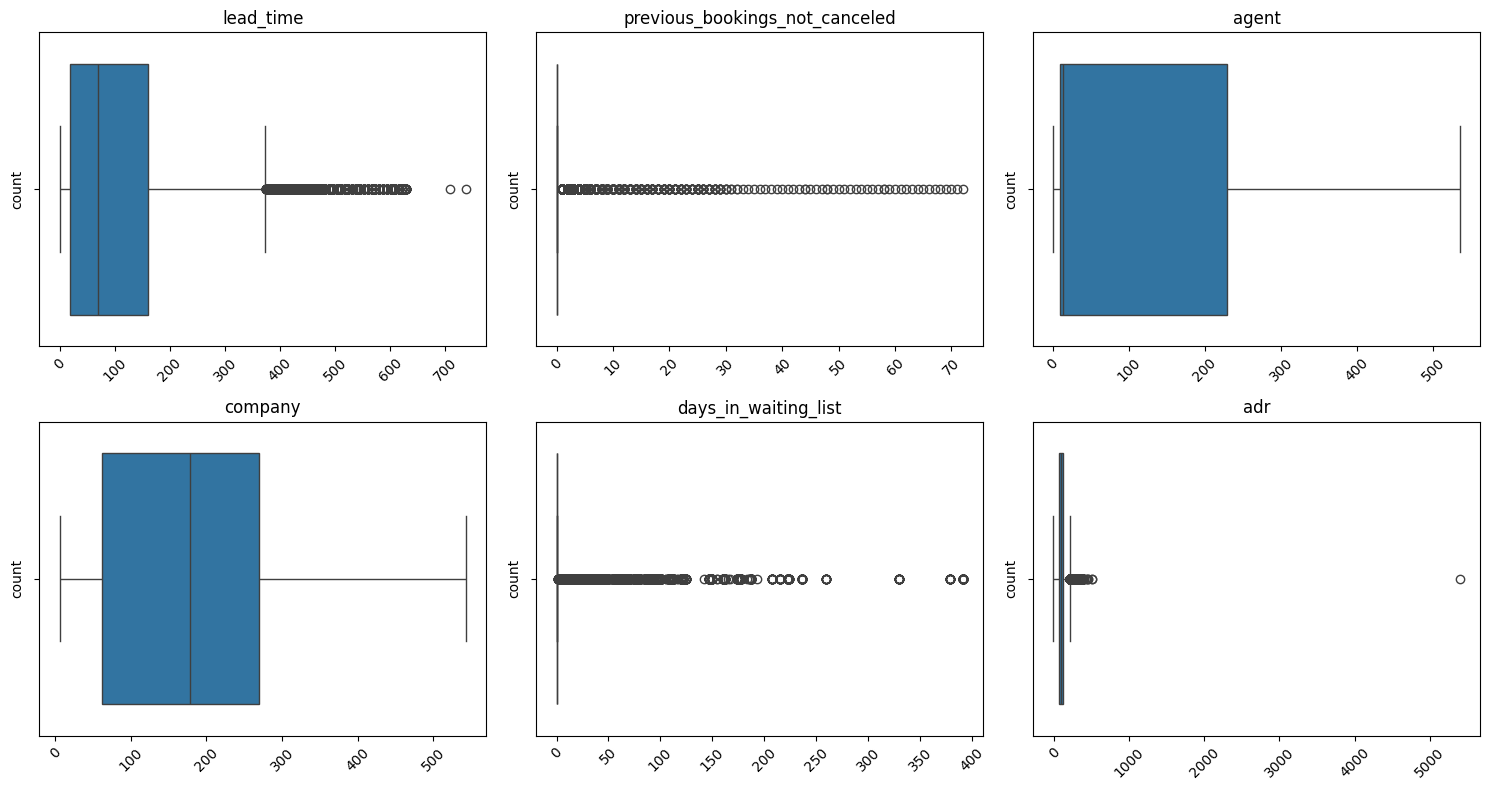

In [101]:
boxplots(q2_df, unbound_df.index)

ADR (que é aproximadamente gasto por noite) tem um outlier absurdo:

In [110]:
q2_df.sort_values(by='adr', ascending=False).head()[['hotel', 'is_canceled', 'adr']]

,hotel,is_canceled,adr
48515,City Hotel,1,5400.000
111403,City Hotel,0,510.000
15083,Resort Hotel,0,508.000
103912,City Hotel,0,451.500
13142,Resort Hotel,1,450.000


Este valor é tão desproporcional e único, que vamos removê-lo da base.

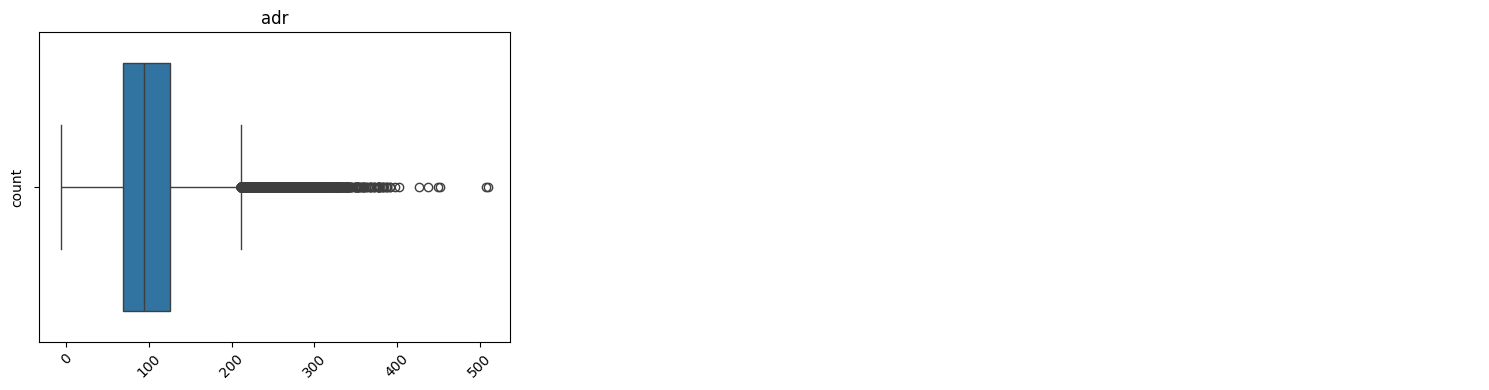

In [111]:
q2_df.drop(q2_df[q2_df['adr'] > 2000].index, inplace=True)
boxplots(q2_df, ['adr'])

#### Histogramas de contagens

In [118]:
def histograms(df, columns, per_row=3, bins=5, width=5, height=4):
    n = len(columns)
    rows = math.ceil(n / per_row)

    fig, axes = plt.subplots(rows, per_row, figsize=(width * per_row, height * rows))
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        sns.histplot(data=df, x=col, ax=ax, bins=bins)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner
        ax.set_ylabel("count")
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

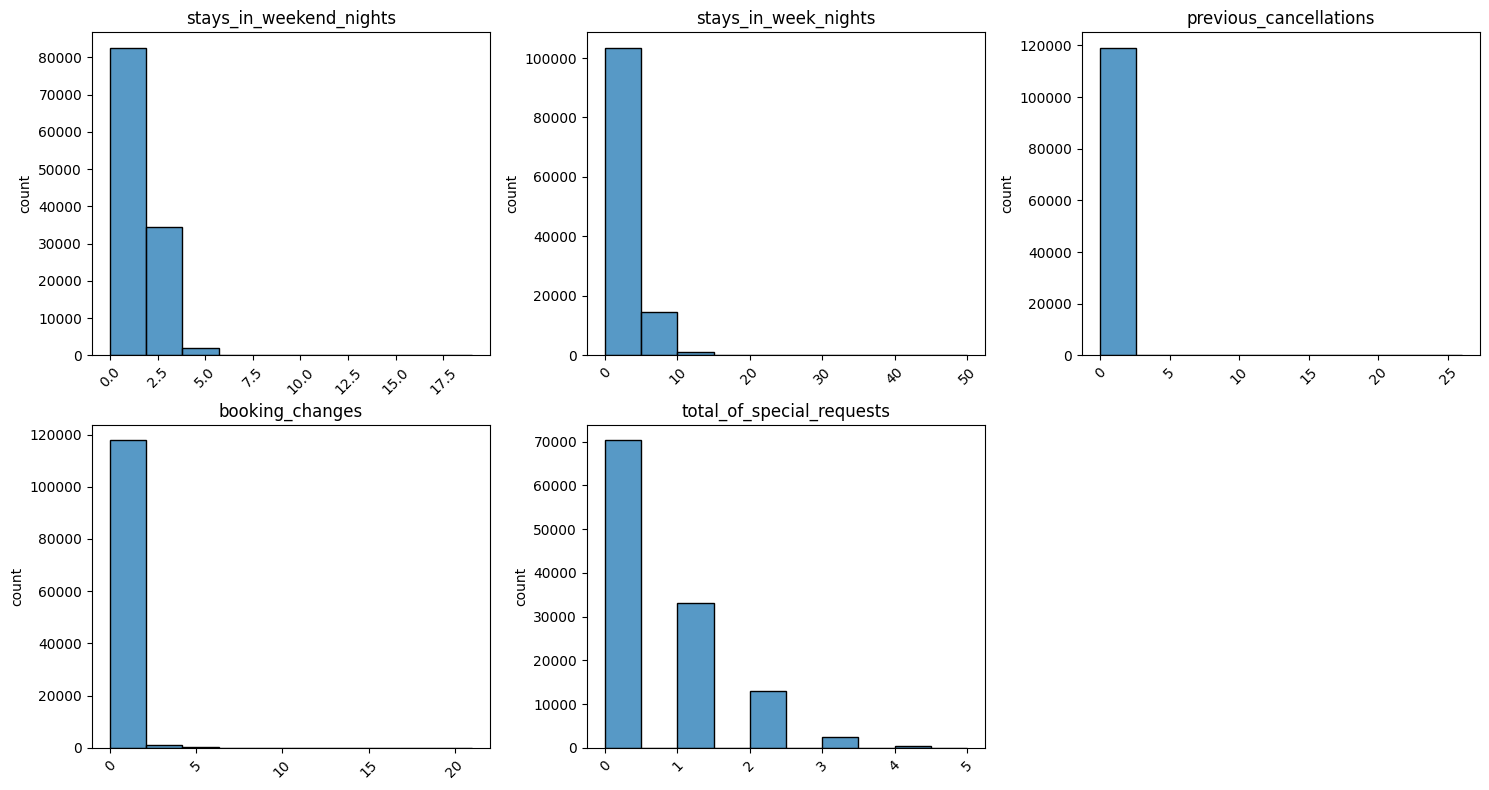

In [120]:
histograms(q2_df, countings_df.index, bins=10)